# Clustering

Group stocks into 4 risk profiles using K-Means.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import sys
sys.path.append('../src')

from clustering import find_optimal_clusters, StockClusterer

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)

## Load Features

In [24]:
df = pd.read_csv('../Data/Processed/nse_features.csv')
print(f"Loaded {len(df)} stocks")
df.head()

Loaded 57 stocks


,Stock_code,Sector,Name,volatility_mean,volatility_max,volatility_7d,downside_deviation,var_95,max_drawdown,mean_return,...,bb_width_mean,macd_volatility,avg_volume,volume_volatility,amihud_illiquidity,trading_frequency,momentum_30d,momentum_90d,trend_strength,current_price
0,ABSA,Banking,ABSA Bank Kenya Plc,0.012541,0.028603,0.011135,0.007830,-0.018083,-0.236220,0.000743,...,2.296415,0.176010,457918.016194,1.206789e+06,3.464928e-09,1.000000,0.160772,0.280142,0.166774,18.05
1,BAMB,Construction and Allied,Bamburi Cement Ltd,0.024157,0.072992,0.021978,0.013723,-0.031429,-0.514563,0.000901,...,3.867892,1.282150,233655.667351,4.414206e+06,1.904103e-08,0.985830,-0.176030,-0.126984,-0.094158,55.00
2,BAT,Manufacturing and Allied,British American Tobacco Kenya Plc,0.012213,0.024126,0.010576,0.007299,-0.016280,-0.348232,0.000126,...,1.752410,5.776191,19173.611111,5.648945e+04,1.622817e-09,0.947368,0.059155,0.082014,0.066576,376.00
3,BKG,Banking,BK Group Plc,0.028502,0.054462,0.025778,0.017173,-0.044569,-0.392500,0.001923,...,3.561992,0.576050,86221.114865,5.454811e+05,0.000000e+00,0.599190,-0.012140,-0.013636,-0.028358,32.55
4,BOC,Manufacturing and Allied,BOC Kenya Plc,0.026053,0.052721,0.021544,0.015937,-0.035582,-0.302949,0.001758,...,3.670978,1.450247,10246.268657,7.566827e+04,0.000000e+00,0.406883,-0.002809,0.053412,0.042829,88.75


## Find Optimal K

In [25]:
# Features for clustering
feature_cols = [
    'volatility_mean', 'volatility_max', 'downside_deviation',
    'std_return', 'var_95', 'max_drawdown',
    'sharpe_ratio', 'return_skew', 'return_kurtosis',
    'rsi_mean', 'bb_width_mean', 'macd_volatility',
    'momentum_30d', 'momentum_90d', 'trend_strength',
    'trading_frequency', 'amihud_illiquidity', 'volume_volatility'
]

# Only use features that exist
feature_cols = [col for col in feature_cols if col in df.columns]
print(f"\nUsing {len(feature_cols)} features")

cluster_metrics = find_optimal_clusters(df, feature_cols, max_clusters=8)
print(cluster_metrics)


Using 18 features


c:\Users\PC\anaconda3\envs\myenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\PC\anaconda3\envs\myenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\PC\anaconda3\envs\myenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\PC\anaconda3\envs\myenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known

   n_clusters      inertia  silhouette
0           2  7208.379906    0.637274
1           3  5874.323149    0.643491
2           4  4778.905927    0.602812
3           5  3873.334188    0.490740
4           6  3188.941094    0.512604
5           7  2445.650558    0.528359
6           8  1785.714366    0.447449


In [26]:
len(feature_cols)

18

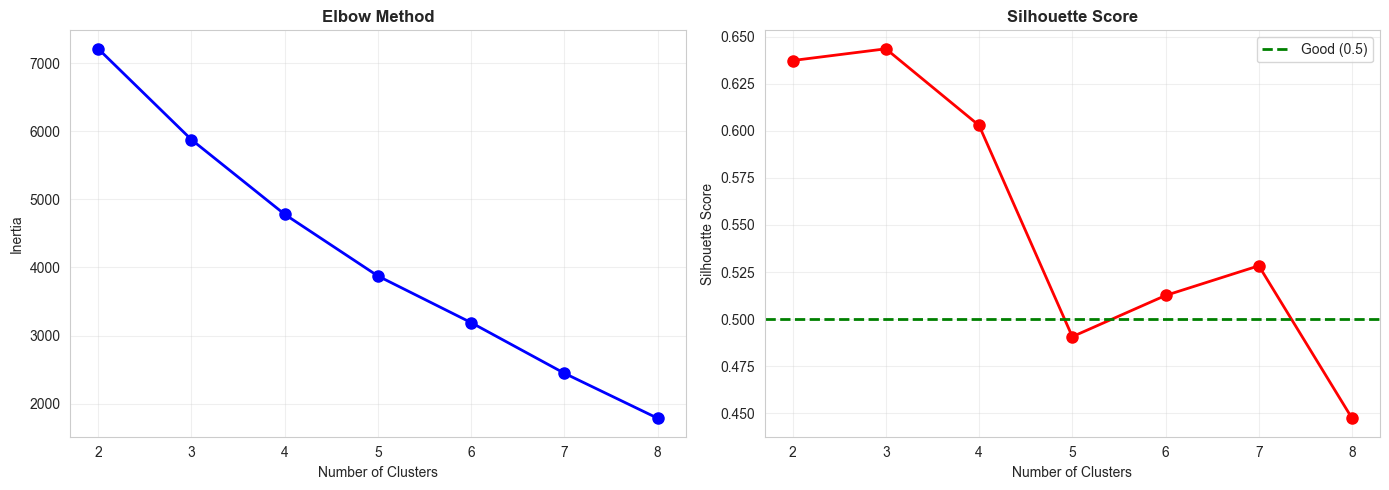


Best K = 3 (highest silhouette)


In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot
ax1.plot(cluster_metrics['n_clusters'], cluster_metrics['inertia'], 'bo-', linewidth=2, markersize=8)
ax1.set_title('Elbow Method', fontweight='bold')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia')
ax1.grid(True, alpha=0.3)

# Silhouette plot
ax2.plot(cluster_metrics['n_clusters'], cluster_metrics['silhouette'], 'ro-', linewidth=2, markersize=8)
ax2.axhline(y=0.5, color='g', linestyle='--', label='Good (0.5)', linewidth=2)
ax2.set_title('Silhouette Score', fontweight='bold')
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Silhouette Score')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

best_k = cluster_metrics.loc[cluster_metrics['silhouette'].idxmax(), 'n_clusters']
print(f"\nBest K = {int(best_k)} (highest silhouette)")

## Train Model

In [28]:
clusterer = StockClusterer(n_clusters=4, random_state=42)
df_clustered = clusterer.fit_predict(df)

print(f"\nCluster Distribution:")
print(df_clustered['Risk_Profile'].value_counts())

Using 15 features for clustering:
std_return, volatility_mean, volatility_max, max_drawdown, downside_deviation, var_95, sharpe_ratio, return_skew, return_kurtosis, rsi_mean, bb_width_mean, momentum_30d, momentum_90d, trading_frequency, amihud_illiquidity


c:\Users\PC\anaconda3\envs\myenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Cluster 0: Low Risk (52 stocks)
Cluster 3: Medium-Low Risk (1 stocks)
Cluster 1: Medium-High Risk (3 stocks)
Cluster 2: High Risk (1 stocks)

✅ Clustering complete!
📊 Silhouette Score: 0.708
🎉 EXCELLENT separation! (≥0.5)

Cluster Distribution:
Risk_Profile
Low Risk            52
Medium-High Risk     3
Medium-Low Risk      1
High Risk            1
Name: count, dtype: int64


## Visualize with PCA

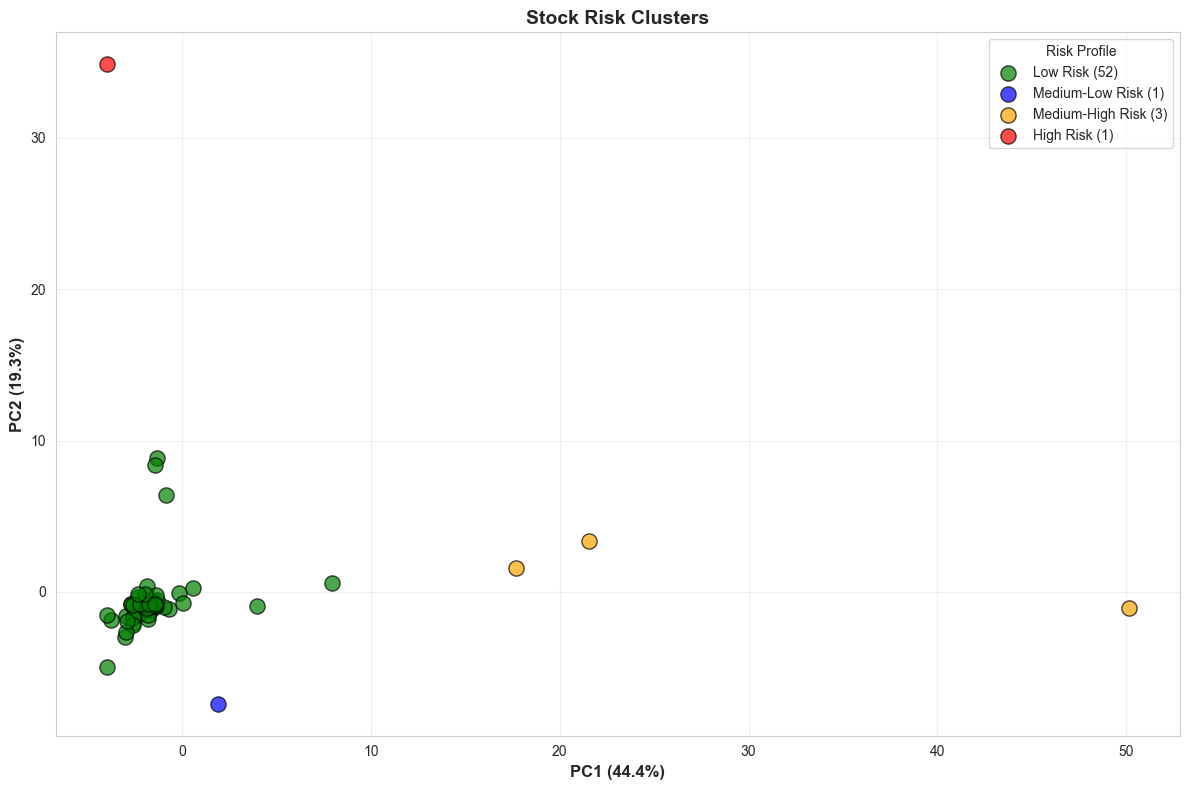

In [29]:
# Prepare data
X = df_clustered[clusterer.feature_columns].fillna(df_clustered[clusterer.feature_columns].median())
X_scaled = clusterer.scaler.transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(12, 8))
colors = ['green', 'blue', 'orange', 'red']
labels = ['Low Risk', 'Medium-Low Risk', 'Medium-High Risk', 'High Risk']

for i, (color, label) in enumerate(zip(colors, labels)):
    mask = df_clustered['Risk_Profile'] == label
    if mask.sum() > 0:
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                    c=color, label=f"{label} ({mask.sum()})",
                    alpha=0.7, s=120, edgecolors='black', linewidth=1)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=12, fontweight='bold')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=12, fontweight='bold')
plt.title('Stock Risk Clusters', fontsize=14, fontweight='bold')
plt.legend(title='Risk Profile', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Cluster Profiles

In [30]:
summary = clusterer.get_cluster_summary(df_clustered)
print("\nCluster Summary:")
print(summary)


Cluster Summary:
                  Count  Avg Volatility  Sharpe Ratio  Avg Drawdown  \
Risk_Profile                                                          
High Risk             1          0.0046        0.8866       -0.0698   
Low Risk             52          0.0272        0.0184       -0.4786   
Medium-High Risk      3          0.0209        0.0140       -0.5520   
Medium-Low Risk       1          0.0222       -0.0102       -0.6376   

                  Trading Freq  Median Volume  
Risk_Profile                                   
High Risk               0.0425     43923.8095  
Low Risk                0.8152     26955.8233  
Medium-High Risk        0.9983    630362.6518  
Medium-Low Risk         1.0000    765106.6802  


## Sample Stocks

In [31]:
for risk in ['Low Risk', 'Medium-Low Risk', 'Medium-High Risk', 'High Risk']:
    subset = df_clustered[df_clustered['Risk_Profile'] == risk]
    if len(subset) > 0:
        print(f"\n{'='*60}")
        print(f"{risk} ({len(subset)} stocks)")
        print('='*60)
        
        cols = ['Stock_code', 'Name', 'Sector', 'volatility_mean', 'sharpe_ratio']
        available_cols = [c for c in cols if c in subset.columns]
        
        sample = subset.nsmallest(min(5, len(subset)), 'volatility_mean')[available_cols]
        print(sample.to_string(index=False))


Low Risk (52 stocks)
Stock_code                               Name                   Sector  volatility_mean  sharpe_ratio
       GLD                   ABSA NewGold ETF    Exchange Traded Funds         0.007653      0.210668
      LIMT                     Limuru Tea Plc             Agricultural         0.008754      0.037256
      SCBK  Standard Chartered Bank Kenya Ltd                  Banking         0.011028      0.052328
       BAT British American Tobacco Kenya Plc Manufacturing and Allied         0.012213      0.001858
      ABSA                ABSA Bank Kenya Plc                  Banking         0.012541      0.047122

Medium-Low Risk (1 stocks)
Stock_code                               Name    Sector  volatility_mean  sharpe_ratio
      KNRE Kenya Re-Insurance Corporation Ltd Insurance         0.022219     -0.010154

Medium-High Risk (3 stocks)
Stock_code                                     Name               Sector  volatility_mean  sharpe_ratio
      KEGN Kenya Electricity Ge

## Save Results

In [32]:
# Save clustered data
df_clustered.to_csv('../Data/Processed/nse_clustered.csv', index=False)
print("Saved clustered data")

# Save model
clusterer.save_model('../models/stock_clusterer.pkl')
print("Saved model")

Saved clustered data
✅ Model saved to ../models/stock_clusterer.pkl
Saved model
